# NLP on the patient dataset using TFIDF and Logistic Regression.

In [93]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import base64


# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
from scipy.misc import imread
from matplotlib import pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from sklearn.metrics import log_loss

from wordcloud import WordCloud, STOPWORDS

In [19]:
#Importing and reading the files

train = pd.read_csv('D:/Documents/train.csv',encoding='unicode_escape')
test = pd.read_csv('D:/Documents/test.csv',encoding='unicode_escape',index_col=0)
sample = pd.read_csv('D:/Documents/sample_submission.csv')

In [20]:
##Viewing the first few records and dropping all the columns except 'TTRANS_CONV_TEXT and Patient_Tag'
train.head()

,Source,Host,Link,Date(ET),Time(ET),time(GMT),Title,TRANS_CONV_TEXT,Patient_Tag
0,FORUMS,cafepharma.com,http://cafepharma.com/boards/threads/epstein.5...,6/15/2016,13:58:00,6/15/2016 23:28,Epstein,I don't disagree with you in principle. I'm ju...,0
1,FORUMS,www.patient.co.uk,http://www.patient.co.uk/forums/discuss/enlarg...,5/7/2016,0.820833333,42498.21667,Enlarged Heart.Thread Enlarged Heart,I am always dizzy I get dizzy standing up so I...,1
2,BLOG,http://abcnewsradioonline.com/entertainment-news,http://abcnewsradioonline.com/entertainment-ne...,4/14/2016,15:00:38,4/15/2016 0:30,Queen Latifah Joins American Heart Association...,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...,0
3,FORUMS,www.cancer-forums.net,http://www.cancer-forums.net/viewtopic.php?f=1...,6/18/2016,20:46:00,6/19/2016 6:16,Bulaemia,I am 17 and I have been throwing up for about ...,1
4,FORUMS,www.diyaudio.com,http://www.diyaudio.com/forums/lounge/292252-d...,6/15/2016,3:26:00,6/15/2016 12:56,DIY Silver interconnects and RCAs???,Quote: Originally Posted by Boyan Silyavski Wa...,0


In [21]:
train.drop(columns=['Source','Host','Link','Date(ET)','Time(ET)','time(GMT)','Title'],inplace = True)
test.drop(columns=['Source','Host','Link','Date(ET)','Time(ET)','time(GMT)','Title'],inplace = True)
test.drop(columns='Unnamed: 9',inplace = True)

In [22]:
y = train.Patient_Tag.values
xtrain, xvalid, ytrain, yvalid = train_test_split(train.TRANS_CONV_TEXT.values.astype('U'), y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

##Shape of the dataset
print(train.shape)
print(xtrain.shape)
print(xvalid.shape)
print(ytrain.shape)
print(yvalid.shape)

(1157, 2)
(1041,)
(116,)
(1041,)
(116,)


# Summary statistics of the training set

Here I will use the Plotly plot to display the number of patients in the dataset. In short, how many patients are there and how many are not.

In [77]:
z = {0: 'Not a patient', 1: 'Patient'}

data = [go.Bar(
            x = train.Patient_Tag.map(z).unique(),
            y = train.Patient_Tag.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.Patient_Tag.value_counts().values
                        ),
            text='Patient Tag'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [78]:
#In the below code, I will display the frequencies of the words in the dataset.

all_words = train['TRANS_CONV_TEXT'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Viridis',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

From the above graph , it is clear that the data needs a lot of pre-processing in order to correctly classify the patients.

In [79]:
#WordCloud to show the words associated with patients and non-patients.

patient = train[train.Patient_Tag==1]['TRANS_CONV_TEXT'].values
nonpatient = train[train.Patient_Tag==0]['TRANS_CONV_TEXT'].values

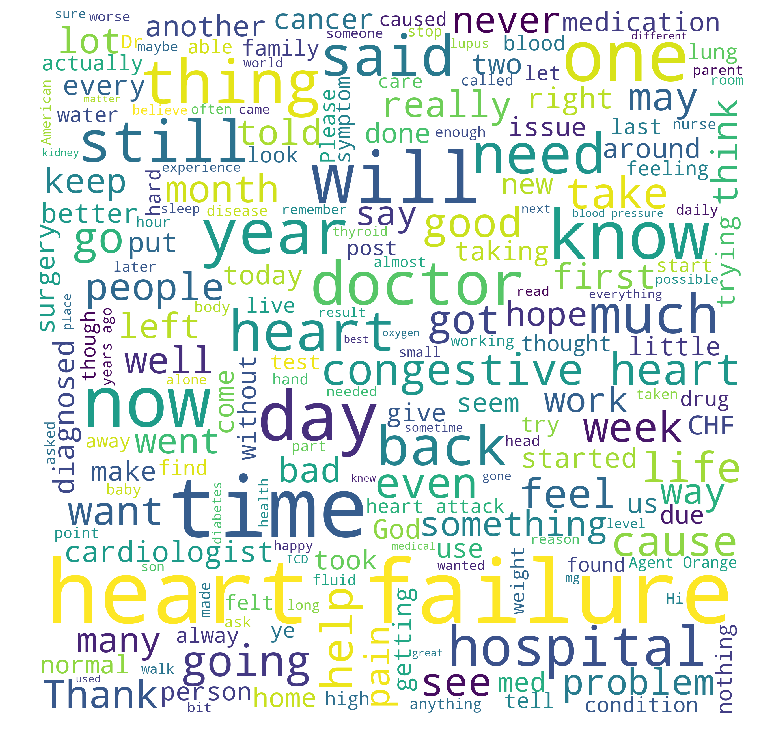

In [80]:
#WordCloud for patients
plt.figure(figsize=(16,13))
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=2500,
                          height=2500
                         ).generate(" ".join(patient))
plt.imshow(cloud)
plt.axis('off')
plt.show()

From the above image, it is clear that the words associated commonly when he/she is a patient are - Heart, failure, hospital, doctor

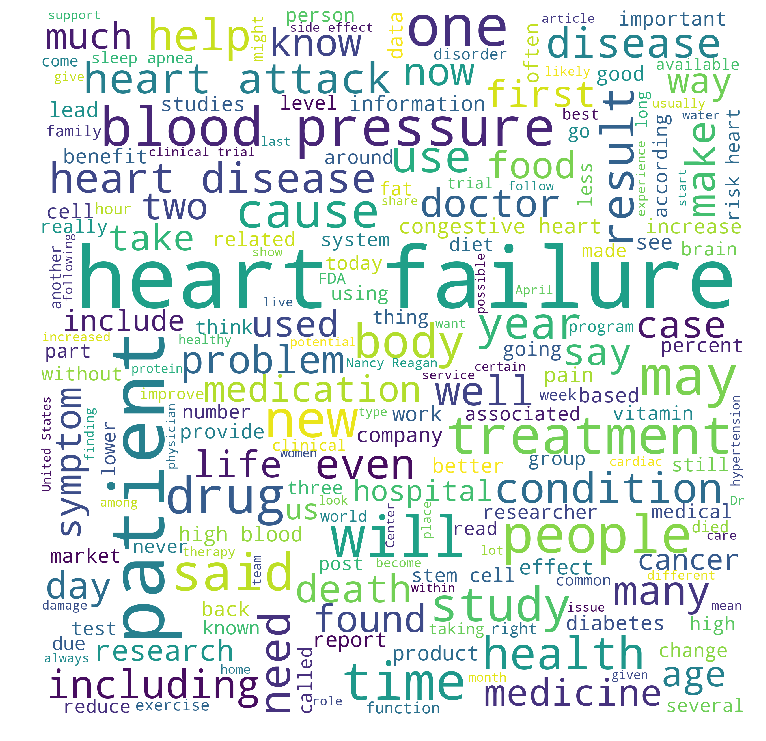

In [81]:
#WordCloud for non-patients
plt.figure(figsize=(16,13))
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=2500,
                          height=2500
                         ).generate(" ".join(nonpatient.astype(str)))
plt.imshow(cloud)
plt.axis('off')
plt.show()

# Building the model
In the NLP Model, I will use the Lemmatizer from NLTK and also use the TFIDF Vectorizer. Then I will use Logistic Regression to train the dataset.

In [43]:
##Using the Lemmatizer to club similar words together as Lemmatizer takes into consideration the vocabulary too unlike the PorterStemmizer.

lemm = nltk.stem.WordNetLemmatizer()

class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


#Storing the entire training text in a list
# Calling our overwritten Count vectorizer
tfv = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')

tfv.fit(list(xtrain) + list(xvalid) + list(test))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

xtest_tfv = tfv.transform(test)

In [85]:
#Using LogisticRegression to train the dataset and predicting it on a test dataset.
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions1 = clf.predict_proba(xvalid_tfv)
predictions = clf.predict(test_tfv)

In [89]:
#Printing the logloss and the accuracy of the model.
print ("logloss: %0.3f " % log_loss(yvalid, predictions1))
acc_log = round(clf.score(xtrain_tfv, ytrain) * 100, 2)
print("Accuracy : %0.3f " % round(acc_log,2,), "%")

logloss: 0.391 
Accuracy : 99.900  %


In [58]:
#Making the final submission.
submission = pd.DataFrame({'Patient_Tag':predictions})
submission.index = np.arange(1,len(submission)+1)
submission.to_csv("D:/Documents/submission.csv",index = True,index_label='Index')

In [92]:
##Viewing the number of patients and Non-patients in the submission set.

z1 = {0: 'Not a patient', 1: 'Patient'}

data = [go.Bar(
            x = submission.Patient_Tag.map(z1).unique(),
            y = submission.Patient_Tag.value_counts().values,
            marker= dict(colorscale='Viridis',
                         color = submission.Patient_Tag.value_counts().values
                        ),
            text='Patient Tag'
    )]

layout = go.Layout(
    title='Target variable distribution in the submission set'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')